In [147]:
import numpy as np
import pandas as pd
import tools as tls
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
def total_housing_loan(house_price, monthly_payment, annual_interest_rate, annual_rise, years):
    """
    Calculate the total amount of money spent to buy a house with loan of interest rate.
    """
    _, total_interest = tls.loan(house_price, monthly_payment, annual_interest_rate, years)
    spent_total = house_price + total_interest
    current_value = house_price * (1 + annual_rise) ** years
    return spent_total, current_value 

def renting(house_price, surface_profit, years):
    """
    Calculate the total amount of money spent to rent a house.
    """
    monthly_rent = house_price * surface_profit / 12
    total_rent = monthly_rent * years * 12
    return total_rent

def unrealized_profit(house_price,surface_profit,years,SP500 = 0.07, annual_interest_rate=0.03):
    """
    Calculate the unrealized profit by buying a house.
    """
    monthly_rent = house_price * surface_profit / 12
    monthly_payment = house_price/years/12
    monthly_SP500 = monthly_payment - monthly_rent
    total_profit = 0
    interest = 0 
    for i in range(years):
        interest = (house_price - monthly_payment*12*i)*annual_interest_rate
        total_profit += (monthly_SP500*12+interest) * (1 + SP500) ** (years-i)
    #total_profit -= 12*monthly_SP500*years
    return total_profit
    

In [ ]:
import itertools

house_prices = np.linspace(3000, 15000, 50)
annual_rises = np.linspace(-0.02, 0.05, 50)
annual_interest_rates = 0.03#np.linspace(0.01, 0.05, 5)
years = 20 # 20 years of loan

# Create all combinations (Cartesian Product)
combinations = list(itertools.product(house_prices, annual_rises))
df = pd.DataFrame(combinations, columns=['house_price', 'annual_rise'])

# Calculate derived columns
df['annual_interest_rate'] = annual_interest_rates
df['monthly_payment'] = df['house_price'] / years / 12
df['surface_profit'] = 0.035 #東京の平均的な表面収益率
df['monthly_rent'] = df['house_price'] * df['surface_profit'] / 12

# We need to make sure calculate_profit_diff is applied AFTER this.
# The next cell does that, so we just setup the df here.


In [150]:
def calculate_profit_diff(row):
    spent, value = total_housing_loan(row['house_price'], row['monthly_payment'], row['annual_interest_rate'], row['annual_rise'], years)
    rent_cost = renting(row['house_price'], row['surface_profit'], years)
    total_profit = unrealized_profit(row['house_price'], row['surface_profit'], years)
    return value - total_profit

df['buy_vs_rent_profit'] = df.apply(calculate_profit_diff, axis=1)
df.head()

,house_price,annual_rise,annual_interest_rate,monthly_payment,surface_profit,monthly_rent,buy_vs_rent_profit
0,3000.0,-0.020000,0.03,12.5,0.05,12.5,-500.852059
1,3000.0,-0.018571,0.03,12.5,0.05,12.5,-441.644948
2,3000.0,-0.017143,0.03,12.5,0.05,12.5,-380.777528
3,3000.0,-0.015714,0.03,12.5,0.05,12.5,-318.205757
4,3000.0,-0.014286,0.03,12.5,0.05,12.5,-253.884487


In [151]:
df[df['buy_vs_rent_profit']>0].head()
df['buy_vs_rent_profit'].describe()

count     2500.000000
mean      5578.885270
std       6011.191230
min      -2504.260296
25%        820.193435
50%       3938.305695
75%       8826.157953
max      27281.085705
Name: buy_vs_rent_profit, dtype: float64

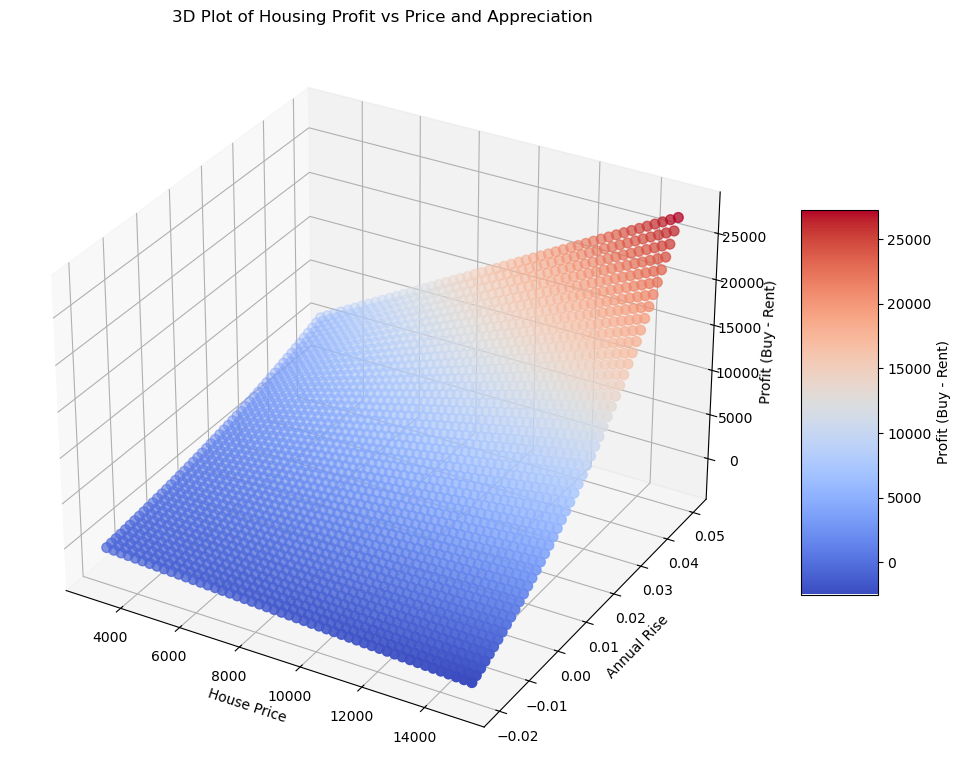

In [152]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Since house_price and annual_rise are coupled 1-to-1 in the dataframe,
# we use a scatter plot to visualize the specific scenarios.
x = df['house_price']
y = df['annual_rise']
z = df['buy_vs_rent_profit']

# Plot the points
vmax = z.max()
scatter = ax.scatter(x, y, z, c=z, cmap='coolwarm', s=50)#,vmin=-vmax,vmax=vmax)


# Add a color bar which maps values to colors
pp = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Profit (Buy - Rent)')
ax.set_xlabel('House Price')
ax.set_ylabel('Annual Rise')
ax.set_zlabel('Profit (Buy - Rent)')
ax.set_title('3D Plot of Housing Profit vs Price and Appreciation')

plt.show()

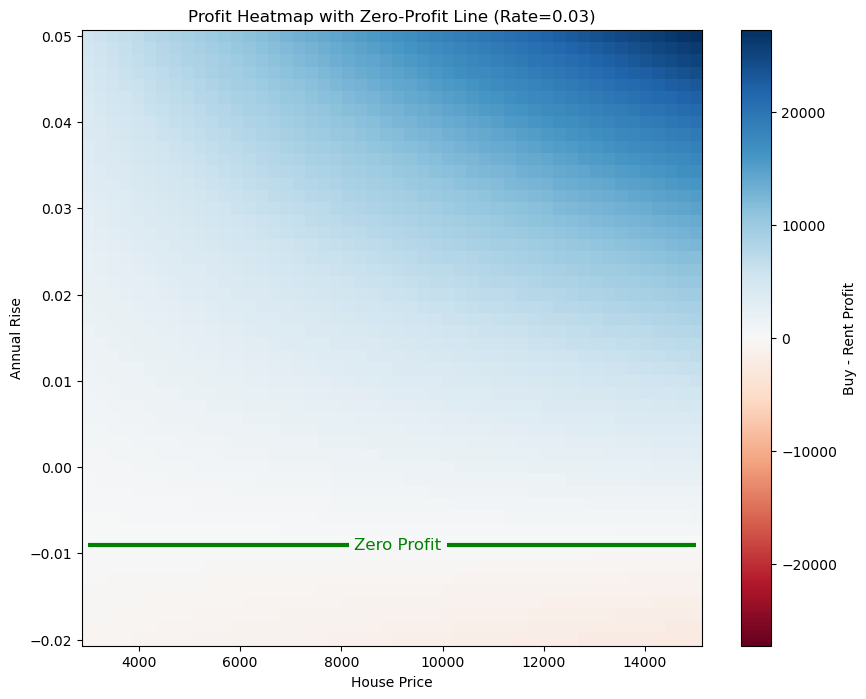

In [153]:
# Heatmap with Separation Line for fixed interest rate of 0.03
target_rate = 0.03
subset = df[np.isclose(df['annual_interest_rate'], target_rate)]

if not subset.empty:
    pivot_table_hm = subset.pivot(index='annual_rise', columns='house_price', values='buy_vs_rent_profit')
    X_hm = pivot_table_hm.columns.values
    Y_hm = pivot_table_hm.index.values
    Z_hm = pivot_table_hm.values
    X_grid_hm, Y_grid_hm = np.meshgrid(X_hm, Y_hm)

    plt.figure(figsize=(10, 8))
    # Use pcolormesh to support data coordinate overlay
    # vmin/vmax centering at 0 for diverging colormap
    limit = max(abs(Z_hm.min()), abs(Z_hm.max()))
    plt.pcolormesh(X_grid_hm, Y_grid_hm, Z_hm, cmap='RdBu', shading='auto', vmin=-limit, vmax=limit)
    plt.colorbar(label='Buy - Rent Profit')
    
    # Draw Zero Profit Line
    CS = plt.contour(X_grid_hm, Y_grid_hm, Z_hm, levels=[0], colors='green', linewidths=3)
    plt.clabel(CS, inline=True, fontsize=12, fmt='Zero Profit')
    
    plt.title(f'Profit Heatmap with Zero-Profit Line (Rate={target_rate})')
    plt.xlabel('House Price')
    plt.ylabel('Annual Rise')
    plt.show()

In [154]:
df[df['annual_rise']>0.011].head()

,house_price,annual_rise,annual_interest_rate,monthly_payment,surface_profit,monthly_rent,buy_vs_rent_profit
22,3000.0,0.011429,0.03,12.5,0.05,12.5,1261.849658
23,3000.0,0.012857,0.03,12.5,0.05,12.5,1369.659899
24,3000.0,0.014286,0.03,12.5,0.05,12.5,1480.398323
25,3000.0,0.015714,0.03,12.5,0.05,12.5,1594.140169
26,3000.0,0.017143,0.03,12.5,0.05,12.5,1710.962498
